# Milestone Project-2: Skim Lit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here :
[PubMed 200k RCT](https://arxiv.org/abs/1710.06071)

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available :
[ANN's for Joint Sentence Classification](https://arxiv.org/abs/1612.05251)


## Get data

Since we'll be replicating the paper above, lets download the dataset they used.

We can do so from the authors GitHub: [Github](https://github.com/Franck-Dernoncourt/pubmed-rct)


!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git


In [66]:
# List the files in the directory

import os
os.listdir('pubmed-rct') 


['.git',
 'PubMed_200k_RCT',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign',
 'PubMed_20k_RCT',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign',
 'README.md']

In [67]:
# Check the contents of the Pub_Med_20k dataset

os.listdir('pubmed-rct/PubMed_20k_RCT')

['dev.txt', 'test.txt', 'train.txt']

In [68]:
# Start our experiments using the 20k dataset with numbers replaced by "@" 

data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [69]:
# Check all of the files in the target directory
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]

print(filenames)

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt', 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt', 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']


## Preprocess data 

Now we've got same text data, now it's time to become one with it.

And one of the best ways to become one with data is to visualize.

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [70]:
 # Create a function to read the lines of a document
def get_lines(filename):
    """
    Reads a filename and returns the lines of text as a list.

    Args:
        filename: a string containing the target filepath.

    Returns:
        A list of strings with one string per line from the target filename.
    """

    with open(filename, "r") as file:
        return file.readlines()

In [71]:
# Lets read in the training data
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look...

A great way to represent would be :


**[{'line_number' : 0,
  'target' : "BACKGROUND",
  'text' : "Emotional eating is associated with overeating and the development of obesity. \n"
  'total_lines' : 11}]**

In [72]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    number of sentences in the current abstract and the sentence number of 
    the target line.

    Args:
        filename: a string containing the target filepath.

    Returns:

    """

    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list to hold abstracts

    for line in (input_lines): # go through each line in the target file

        if line.startswith("###"): # determine the ID lines
            abstract_id = line
            abstract_lines = "" # reset the abstract string 

        elif line.isspace(): # check if line is empty (\n line)
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
                line_data["total_lines"] = (len(abstract_line_split) - 1) # how many total lines are in the abstract
                abstract_samples.append(line_data) # add line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line contains abstract text
            abstract_lines += line        

    return abstract_samples        

In [73]:
# Get data from file and preprocess it

train_dir = data_dir + "train.txt"

train_samples = preprocess_text_with_line_numbers(train_dir)

val_dir = data_dir + "dev.txt"

val_samples = preprocess_text_with_line_numbers(val_dir) 

test_dir = data_dir + "test.txt"

test_samples = preprocess_text_with_line_numbers(test_dir)

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

Note that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [74]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [75]:
# Distribution of labels in training data

train_df.target.value_counts() # get the count of each target label in the training data

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

## Usage of plot.hist()

1. train_df.total_lines: This accesses the total_lines column from the train_df DataFrame.
2. plot: This is a method provided by Pandas for quick visualization.
3. hist(): This generates a histogram, which shows the distribution of values in the total_lines column.

A **histogram** is a type of plot that shows how frequently different ranges of values appear in the data. It divides the data into bins (intervals) and counts how many values fall into each bin.

<Axes: ylabel='Frequency'>

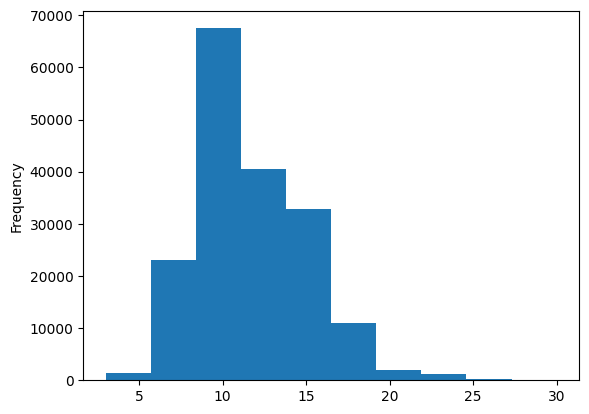

In [76]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences 

In [77]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels 

In [78]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = tf.constant(one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1)))
val_labels_one_hot = tf.constant(one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1)))
test_labels_one_hot = tf.constant(one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1)))


print(train_labels_one_hot, val_labels_one_hot, test_labels_one_hot)

tf.Tensor(
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]], shape=(180040, 5), dtype=float64) tf.Tensor(
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]], shape=(30212, 5), dtype=float64) tf.Tensor(
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]], shape=(30135, 5), dtype=float64)


In [79]:
# Label encode labels (extract labels and encode them into integers)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())


# Check what training labels look like
print(train_labels_encoded, val_labels_encoded, test_labels_encoded)

[3 2 2 ... 4 1 1] [0 0 3 ... 4 1 1] [0 4 4 ... 4 4 1]


In [80]:
# Get class names and number of classes from LabelEncoder instance

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f"Number of classes: {num_classes}\nClass Names: {class_names}")

Number of classes: 5
Class Names: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## Starting a series of modelling experiments...

A bunch of different models will be tested to check which one is optimal for our problem

## Baseline Model will be a TF-IDF Multinomial Naive Bayes Classifier

**TF-IDF(Term Frequency-Inverse Document Frequency):** is a statistical measure used in natural language processing and information retrieval to evaluate the importance of a word in a document relative to a collection of documents (corpus).

**Multinomial Naive Bayes:**  Theorem ideal for discrete data and is typically used in text classification problems. It models the frequency of words as counts and assumes each feature or word is multinomially distributed.

In [81]:
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline # similar to initalize a Sequential Model used in TF

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Converts words into numbers
    ("clf", MultinomialNB()) # Model the text
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [82]:
# Evaluate baseline model on validation set
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [83]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
print(f"Predictions: {baseline_preds}")

Predictions: [4 1 3 ... 4 4 1]


# Download helper function script

In my previous experiments, i've written a function to compare predictions across different metrics (accuracy, precision, recall, F1-Score) and rather than rewriting it here, i'll import from my helper function script

In [84]:
from helper_functions import calculate_eval_metrics

baseline_results = calculate_eval_metrics(y_true=val_labels_encoded, y_pred=baseline_preds)
print(baseline_results)

{'accuracy': 72.1832384482987, 'precision': 0.7186466952323352, 'recall': 0.7218323844829869, 'f1-score': 0.6989250353450294}


## Preparing our data (the text) for deep sequence models

Before starting to build deeper models, create vectorization and embedding layers.

In [85]:
# How long is each sentence on average?
import numpy as np

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = round(np.mean(sent_lens))
std_dev = np.std(sent_lens)

print(avg_sent_len)

26


(array([4.6220e+03, 2.0864e+04, 3.5052e+04, 3.6426e+04, 2.8882e+04,
        2.0006e+04, 1.2593e+04, 7.6670e+03, 4.8980e+03, 2.6580e+03,
        2.0780e+03, 1.3590e+03, 8.9500e+02, 6.0000e+02, 4.4400e+02,
        2.9300e+02, 2.0300e+02, 1.2500e+02, 1.0000e+02, 6.5000e+01,
        4.9000e+01, 3.6000e+01, 2.6000e+01, 2.3000e+01, 1.2000e+01,
        8.0000e+00, 1.1000e+01, 4.0000e+00, 5.0000e+00, 4.0000e+00,
        3.0000e+00, 3.0000e+00, 6.0000e+00, 2.0000e+00, 5.0000e+00,
        3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,   6.9,  12.8,  18.7,  24.6,  30.5,  36.4,  42.3,  48.2,
         54.1,  60. ,  65.9,  71.8,  77.7,  83.6,  89.5,  95.4, 101.3,
        107.2, 113.1, 119. , 124.9, 130.8, 136.7, 142.6, 148.5, 154.4,
        160.3, 166.2, 172.1, 178. , 183.9, 189.8, 195.7, 201.6, 207.5,
        213.4, 219.3, 225.2, 231.1

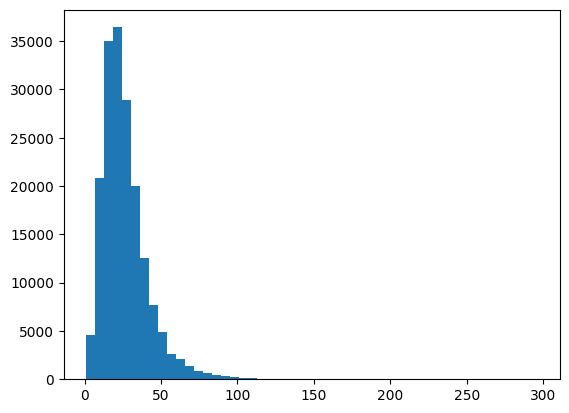

In [86]:
# What does the distribution look like?
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=50)

In [87]:
# How long of a sentence length covers %95 of examples

output_seq_len = int(np.percentile(sent_lens, 95))
print(output_seq_len)

55


In [88]:
# Maximum sequence length in the training set
print(max(sent_lens))

296


In [89]:
# Create a text vectorization layer (map our texts from words to numbers) now with the knowledge of our text data
from tensorflow.keras import layers

max_vocab_length = 68000 # Max number of words to have in our vocabulary (68k is taken from the original PubMed paper)

text_vectorizer = layers.TextVectorization(max_tokens = max_vocab_length,
                                           output_sequence_length = output_seq_len)

# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [90]:
# Test text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)

print(f"Original sentence: {target_sentence}\n"
      f"Length of the text: {len(target_sentence.split())}\n"
      f"Vectorized text: {text_vectorizer([target_sentence])}")


Original sentence: there was no significant difference in the @-day probability of hospitalization between the mtm intervention and control groups ( adjusted or : @ , @ percent ci : @-@ @ , p = @ ) .
Length of the text: 36
Vectorized text: [[   61    10    33    37    74     5     2   108  1641     4   843    30
      2 11503    38     3    35    24   411    16   795    50    14     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [91]:
# How many words in training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

print(f"Number of words in the vocab: {len(rct_20k_text_vocab)}\n"
      f"Most common words in the vocab: {rct_20k_text_vocab[:10]}\n"
      f"Least common words in the vocab: {rct_20k_text_vocab[-10:]}\n")
      

Number of words in the vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common words in the vocab: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']



In [92]:
# Get the config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [93]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=max_vocab_length, # length of the vocabulary
                               output_dim=128, # embedding size for each token
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name="token_embedding")

In [94]:
# Show example embedding
text_vectorized_sentence = text_vectorizer(target_sentence)
token_embedded_sentence = token_embed(text_vectorized_sentence)

print(f"Original sentence:\n{target_sentence}\n\n"
      f"Sentence after vectorization:\n{text_vectorized_sentence}\n\n"
      f"Sentence after embedding:\n{token_embedded_sentence}\n")

Original sentence:
there was no significant difference in the @-day probability of hospitalization between the mtm intervention and control groups ( adjusted or : @ , @ percent ci : @-@ @ , p = @ ) .

Sentence after vectorization:
[   61    10    33    37    74     5     2   108  1641     4   843    30
     2 11503    38     3    35    24   411    16   795    50    14     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]

Sentence after embedding:
[[-0.01374888 -0.04221928 -0.04251244 ... -0.04883705 -0.04389
  -0.04585489]
 [ 0.04075339  0.00097812 -0.03345891 ...  0.03534232 -0.03822708
   0.01812128]
 [ 0.00333346 -0.01990588  0.01757339 ... -0.0093955  -0.04253919
  -0.03783978]
 ...
 [ 0.04771822 -0.02020823 -0.04913101 ...  0.00884926  0.02250736
   0.00114876]
 [ 0.04771822 -0.02020823 -0.04913101 ...  0.00884926  0.02250736
   0.00114876]

## Creating datasets to ensure loading the data as fast as possible

Setup the data with the TensorFlow tf.data API to optimize loading process

Resources:

**[TF Data Performance](https://www.tensorflow.org/guide/data_performance)**

**[TF Data](https://www.tensorflow.org/guide/data)**


In [95]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset  = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [96]:
# Take the TensorSliceDataset's and turn them into prefetched datasets

def batch_and_prefetch(dataset, batch_size=32):

    """
    Takes a dataset and turns it into a batched and prefetched dataset.

    Args:
        dataset: a tf.data.Dataset object.
        batch_size: int, the batch size of the dataset.

    Returns:
        Batched and prefetched tf.data.Dataset.    
    """

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_dataset = batch_and_prefetch(train_dataset)
valid_dataset = batch_and_prefetch(valid_dataset)
test_dataset = batch_and_prefetch(test_dataset)

# Model 1: Conv1D with token embeddings

In [97]:
# Create 1D CNN model to process sequences

# Input layer
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Turn text into numbers and then into an embedding
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)


# Conv1D + MaxPooling1D layers
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.MaxPooling1D(pool_size=2)(x)

x = layers.Conv1D(filters=128, kernel_size=5, padding="same", activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2)(x)

x = layers.Conv1D(filters=256, kernel_size=5, padding="same", activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2)(x)

# Global Max Pooling
x = layers.GlobalMaxPooling1D()(x)

# Output layer
outputs = layers.Dense(num_classes, activation="softmax") (x)

# Construct the model
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

c:\Users\LENOVO\venv\Lib\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [98]:
# Check summary of the model
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,704,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 27, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 13, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951,493 (34.15 MB)

 Trainable params: 8,951,493 (34.15 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs = 3,
                              validation_data = valid_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_steps = int(0.1 * len(valid_dataset))) 

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - accuracy: 0.5527 - loss: 1.0518 - val_accuracy: 0.7736 - val_loss: 0.6129
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 80s 143ms/step - accuracy: 0.7733 - loss: 0.6106 - val_accuracy: 0.8042 - val_loss: 0.5393
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 79s 141ms/step - accuracy: 0.7886 - loss: 0.5738 - val_accuracy: 0.8118 - val_loss: 0.5126


In [100]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8066 - loss: 0.5245


[0.5259727239608765, 0.8067654967308044]

In [101]:
# Make predictions on the validation dataset
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

print(f"Predictions {model_1_preds}")

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
Predictions [0 1 3 ... 4 1 1]


In [102]:
# Calculate model_1 results
calculate_eval_metrics(y_true = val_labels_encoded,
                       y_pred = model_1_preds)

{'accuracy': 80.67655236329935,
 'precision': 0.8047289349349315,
 'recall': 0.8067655236329935,
 'f1-score': 0.8048665756919338}

## Model 2: Feature extraction with pre-trained token embeddings